In [2]:
import torch
torch.__version__

'1.12.1+cu116'

In [15]:
import json

with open('/data/ephemeral/home/dataset/train.json') as json_file:
    json_data = json.load(json_file)


In [22]:
import random
train_len = len(json_data['images'])
samples = random.sample(range(train_len),int(train_len*0.2))
len(json_data['images'][:int(train_len*0.2)])


976

In [4]:
# 모듈 import

from mmcv.utils import config
from mmdet.datasets import build_dataset
from .coco import CocoDataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.utils import get_device

ImportError: cannot import name 'build_dataset' from 'mmdet.datasets' (/data/ephemeral/home/mmdetection/mmdet/datasets/__init__.py)

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='../dataset/'

cfg.data_root = root
cfg.num_last_epochs = 3
cfg.interval = 1
# dataset config 수정
cfg.data.train.classes = classes
cfg.data.train.img_prefix = root
cfg.data.train.ann_file = root + 'train.json' # train json 정보

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json' # test json 정보

cfg.data.samples_per_gpu = 4

cfg.seed = 2022
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/codetr_r50_trash'
cfg.auto_scale_lr = dict(enable=False, base_batch_size=16)

cfg.model.query_head.num_classes = 10
cfg.model.roi_head.bbox_head.num_classes = 10
cfg.model.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1)
cfg.device = get_device()

cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='MMDetWandbHook',
         init_kwargs={'project': 'hanseungsoo63-naver'},
         interval=10, #10step 마다 하나씩 기록
         log_checkpoint=True,
         log_checkpoint_metadata=True,
         num_eval_images=100)]

In [3]:
# build_dataset
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [4]:
# dataset 확인
datasets[0]


CocoDataset Train dataset with number of images 4883, and instance counts: 
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| category          | count | category      | count | category        | count | category    | count | category     | count |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| 0 [General trash] | 3965  | 1 [Paper]     | 6352  | 2 [Paper pack]  | 897   | 3 [Metal]   | 936   | 4 [Glass]    | 982   |
| 5 [Plastic]       | 2943  | 6 [Styrofoam] | 1263  | 7 [Plastic bag] | 5178  | 8 [Battery] | 159   | 9 [Clothing] | 468   |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+

In [ ]:
# 모델 build 및 pretrained network 불러오기
model = build_detector(cfg.model)
model.init_weights()

In [ ]:
# 모델 학습
train_detector(model, datasets[0], cfg, distributed=False, validate=False)

In [2]:
import pickle
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import os


# pkl 파일을 열고 객체를 불러오는 함수
def load_pickle(file_path):
    with open(file_path, 'rb') as f:  # 'rb'는 바이너리 읽기 모드
        data = pickle.load(f)  # pickle.load를 사용해 파일 내용 불러오기
    return data

# 예시: 'example.pkl' 파일을 불러오기
file_path = '/data/ephemeral/home/mmdetection/result_ddq_swinl_eval.pkl'
loaded_data = load_pickle(file_path)

In [13]:

# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO('../dataset/evaluation_nonannot.json')
img_ids = coco.getImgIds()
epoch = 'ddq_eval'
work_dir = './work_dirs/ddq_train/20241011_121636'

class_num = 10
for i, out in zip(img_ids,loaded_data):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    box_num = sum(out['pred_instances']['scores']>0.1)
    for o in range(box_num):
        label, box, score = out['pred_instances'].values()
        prediction_string += str(label[o].item()) + ' ' + str(score[o].item()) + ' ' + str(box[o][0].item()) + ' ' + str(box[o][1].item()) + ' ' + str(box[o][2].item()) + ' ' + str(box[o][3].item()) + ' '
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


,PredictionString,image_id
0,0 0.5840889811515808 196.74127197265625 191.33...,train/0000.jpg
1,4 0.5516769886016846 737.1624755859375 314.921...,train/0001.jpg
2,3 0.7258724570274353 273.0506286621094 158.043...,train/0002.jpg
3,2 0.6757146716117859 461.41192626953125 367.85...,train/0003.jpg
4,1 0.44167715311050415 486.08514404296875 459.0...,train/0004.jpg


In [123]:
import json

# 원본 COCO test.json 파일 경로
input_json_path = '../dataset/test.json'

# 새로운 json 파일 경로 (50개 annotation만 포함)
output_json_path = '../dataset/test_50_annotations.json'

# COCO 형식의 test.json 파일 읽기
with open(input_json_path, 'r') as f:
    coco_data = json.load(f)

# annotations의 상위 50개 항목만 선택
coco_data['images'] = coco_data['images'][:50]

# 관련 이미지 및 카테고리만 남기기 위한 필터링
annotation_image_ids = {ann['id'] for ann in coco_data['images']}

# 해당 annotation과 관련된 image들만 남김
coco_data['annotations'] = [img for img in coco_data['annotations'] if img['id'] in annotation_image_ids]

# 선택된 annotation의 카테고리들만 남김
annotation_category_ids = {ann['category_id'] for ann in coco_data['annotations']}
coco_data['categories'] = [cat for cat in coco_data['categories'] if cat['id'] in annotation_category_ids]

# 50개 annotation만 포함된 새로운 json 파일 저장
with open(output_json_path, 'w') as f:
    json.dump(coco_data, f, indent=4)

print(f"Saved 50 annotations to {output_json_path}")

Saved 50 annotations to ../dataset/test_50_annotations.json


In [124]:
from pycocotools.coco import COCO
import cv2
import numpy as np
import matplotlib.pyplot as plt

classes = {0:"general trash",1:"Paper",2:"Paper pack",3:"Metal",4:"Glass",5:"Plastic",6:"Styrofoam",7:"Plastic bag",8:"Battery",9:"Clothing"}
output_dir = 'results/ddq_eval0'
os.makedirs(output_dir, exist_ok=True)

def visulize(img_info,pred,gt,data_root='../dataset',threshold=0.3):
    file_name = os.path.join(data_root,img_info['file_name'])
    img = np.array(cv2.imread(file_name))
    if img is None:
        print(f"Unable to read image: {file_name}")
    
    thresholds = pred['pred_instances']['scores']>threshold
    labels = pred['pred_instances']['labels'][thresholds]
    boxes = pred['pred_instances']['bboxes'][thresholds]
    confidences = pred['pred_instances']['scores'][thresholds]

    for label,k,confidence in zip(labels,boxes,confidences):
        label_num = int(label)  # 첫 번째 요소를 라벨로 사용
        label = classes[label_num]
        confidence = float(confidence)  # 두 번째 요소를 신뢰도로 사용
        pt1 = (int(float(k[0])), int(float(k[1])))
        pt2 = (int(float(k[2])), int(float(k[3])))
        
        # 바운딩 박스 그리기
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
        
        # 라벨 텍스트 준비
        label_text = f"{label}: {confidence:.2f}"
        
        # 라벨 배경 크기 계산
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        
        # 라벨 배경 그리기
        cv2.rectangle(img, 
                    (pt1[0], pt1[1] - text_size[1] - 4), 
                    (pt1[0] + text_size[0], pt1[1]), 
                    (0, 255, 0), 
                    -1)
        
        # 라벨 텍스트 그리기
        cv2.putText(img, label_text, 
                    (pt1[0], pt1[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    for bbox in gt:
        x_min = int(bbox[0])
        y_min = int(bbox[1])
        x_max = int(bbox[0]+bbox[2])
        y_max = int(bbox[1]+bbox[3])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (256, 0, 0), 2)

    # 이미지 저장 (필요한 경우 주석 해제)
    i = image_info['id']
    output_path = os.path.join(output_dir, f'output_{i}.png')
    cv2.imwrite(output_path, img)
    

    

coco = COCO('../dataset/evaluation_annot.json')
img_ids = coco.getImgIds()
for id, out in zip(img_ids,loaded_data):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    gt_boxes = []
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
    visulize(image_info,out,gt_boxes,threshold=0.2)
# 진행 상황 출력 (100개마다)
    if (id + 1) % 100 == 0:
        print(f"Processed {id + 1} images")

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3200 images
Processed 3300 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 images
Processed 4700 images
Processed 4800 images


In [10]:
def compute_iou(pred_box, gt_box):
    # pred_box and gt_box are [x_min, y_min, x_max, y_max]
    gt_box[0] = float(gt_box[0])
    gt_box[1] = float(gt_box[1])
    gt_box_x_max = float(gt_box[0]+gt_box[2])
    gt_box_y_max = float(gt_box[1]+gt_box[3])
    
    # Intersection coordinates
    x_min = max(float(pred_box[0]), gt_box[0])
    y_min = max(float(pred_box[1]), gt_box[1])
    x_max = min(float(pred_box[2]), gt_box_x_max)
    y_max = min(float(pred_box[3]), gt_box_y_max)
    
    # Intersection area
    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
    
    # Predicted box area and Ground truth box area
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box_x_max - gt_box[0]) * (gt_box_y_max - gt_box[1])
    
    # Union area
    union = pred_area + gt_area - intersection
    
    # IoU calculation
    iou = intersection / union if union != 0 else 0
    return iou

def compute_precision_recall(pred_boxes, gt_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    matched_gt = set()  # To keep track of matched ground truth boxes
    
    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        
        for i, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou and iou >= iou_threshold and i not in matched_gt:
                best_iou = iou
                best_gt_idx = i
        
        if best_gt_idx >= 0:
            tp += 1  # True positive
            matched_gt.add(best_gt_idx)
        else:
            fp += 1  # False positive
    
    # Remaining unmatched ground truth boxes are false negatives
    fn = len(gt_boxes) - len(matched_gt)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

def compute_average_precision(precisions, recalls):
    # Sort by recall
    recalls, precisions = zip(*sorted(zip(recalls, precisions)))

    ap = 0
    prev_recall = 0
    for p, r in zip(precisions, recalls):
        ap += p * (r - prev_recall)
        prev_recall = r
    
    return ap

def calculate_map(pred_boxes_list, gt_boxes_list, iou_threshold=0.5):
    all_precisions = []
    all_recalls = []

    for pred_boxes, gt_boxes in zip(pred_boxes_list, gt_boxes_list):
        precision, recall = compute_precision_recall(pred_boxes, gt_boxes, iou_threshold)
        all_precisions.append(precision)
        all_recalls.append(recall)
    mAP = compute_average_precision(all_precisions,all_recalls)
    return precision,recall, mAP


In [11]:
coco = COCO('../dataset/evaluation_annot.json')
img_ids = coco.getImgIds()
maps = []
ps = []
rs = []
cs = []
iou_threshold=0.5
for id, out in zip(img_ids,loaded_data):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    gt_boxes = []
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
    thresholds = out['pred_instances']['scores']>0.2
    boxes = out['pred_instances']['bboxes'][thresholds]
    p,r,c = calculate_map([boxes],[gt_boxes],iou_threshold)
    ps.append(p)
    rs.append(r)
    cs.append(c)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [5]:
coco = COCO('../dataset/evaluation_annot.json')
img_ids = coco.getImgIds()
maps = []
ps = []
rs = []
boxess = []
all_gts = []

iou_threshold=0.5
for id, out in zip(img_ids,loaded_data):
    gt_boxes = []
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
    thresholds = out['pred_instances']['scores']>0.2
    all_gts.append(gt_boxes)
    boxess.append(out['pred_instances']['bboxes'][thresholds])
mp,mc,mp = calculate_map(boxess,all_gts,iou_threshold)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [12]:
for i,(p,r) in enumerate(zip(ps,rs)):
    if p==0 and r==0:
        print(i, img_ids[i])

712 872
1567 1950
1952 2429
2846 3537
3338 4150


In [14]:
anns[0]['category_id']

{'image_id': 4881,
 'category_id': 7,
 'area': 202051.41,
 'bbox': [151.4, 484.8, 540.1, 374.1],
 'iscrowd': 0,
 'id': 23138}

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def compute_iou(pred_box, gt_box):
    # pred_box and gt_box are [x_min, y_min, x_max, y_max]
    gt_box[0] = float(gt_box[0])
    gt_box[1] = float(gt_box[1])
    gt_box_x_max = float(gt_box[0]+gt_box[2])
    gt_box_y_max = float(gt_box[1]+gt_box[3])
    
    # Intersection coordinates
    x_min = max(float(pred_box[0]), gt_box[0])
    y_min = max(float(pred_box[1]), gt_box[1])
    x_max = min(float(pred_box[2]), gt_box_x_max)
    y_max = min(float(pred_box[3]), gt_box_y_max)
    
    # Intersection area
    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
    
    # Predicted box area and Ground truth box area
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box_x_max - gt_box[0]) * (gt_box_y_max - gt_box[1])
    
    # Union area
    union = pred_area + gt_area - intersection
    
    # IoU calculation
    iou = intersection / union if union != 0 else 0
    return iou

def compute_labels(pred_boxes, gt_boxes, pred_labels, gt_labels, iou_threshold=0.5):
    pred,target = [],[]
    matched_gt = set()  # To keep track of matched ground truth boxes
    
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_gt_idx = -1
        
        for j, pred_box in enumerate(pred_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou and iou >= iou_threshold and i not in matched_gt:
                best_iou = iou
                best_gt_idx = i
                best_pred_idx = j
        
        if best_gt_idx >= 0:
            pred.append(pred_labels[best_pred_idx])
            target.append(gt_labels[best_gt_idx])
            matched_gt.add(best_gt_idx)

    return pred, target

def show_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=[classes[i] for i in range(10)], 
                yticklabels=[classes[i] for i in range(10)])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Multi-Class Classification')
    plt.show()

def calculate_confusion_matrix(pred_boxes_list, gt_boxes_list, pred_labels_list,gt_labels_list,iou_threshold=0.5):
    all_preds = []
    all_targets = []

    for pred_boxes, gt_boxes, pred_labels, gt_labels in zip(pred_boxes_list, gt_boxes_list, pred_labels_list, gt_labels_list):
        precision, recall = compute_labels(pred_boxes, gt_boxes, pred_labels, gt_labels, iou_threshold)
        all_preds.extend(precision)
        all_targets.extend(recall)
    show_confusion_matrix(all_preds,all_targets)




loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


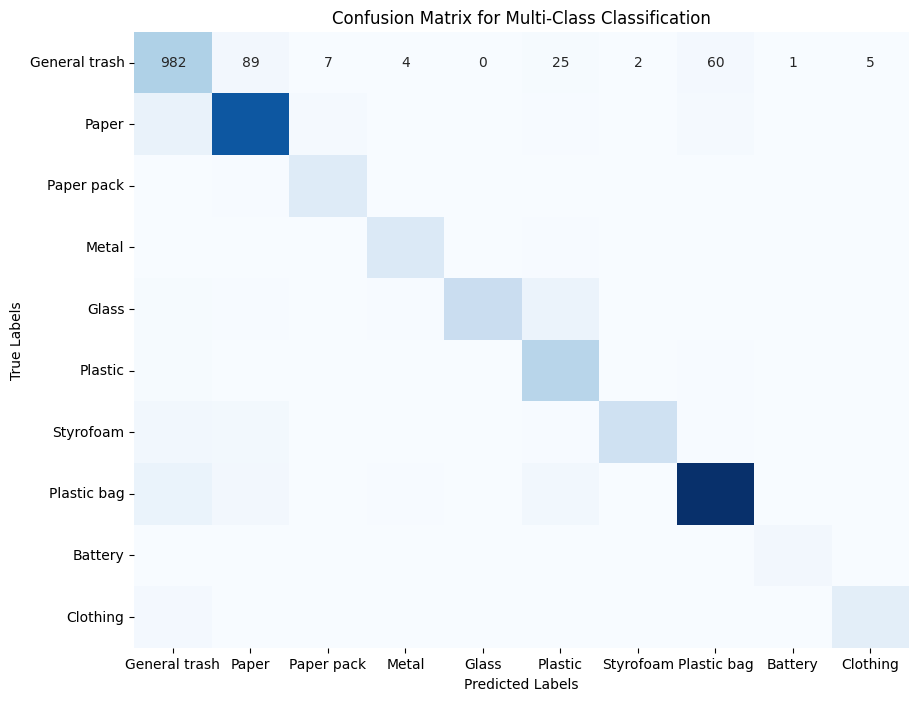

In [15]:
coco = COCO('../dataset/evaluation_annot.json')
img_ids = coco.getImgIds()
trues = []
preds = []
preds_labels = []
true_labels = []
true_boxes = []
iou_threshold=0.5
for id, out in zip(img_ids,loaded_data):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    gt_boxes = []
    gt_labels = []
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
        gt_labels.append(anns[0]['category_id'])
    thresholds = out['pred_instances']['scores']>0.2
    labels = out['pred_instances']['labels'][thresholds]
    boxes = out['pred_instances']['bboxes'][thresholds]

    true_labels.append(gt_labels)
    true_boxes.append(gt_boxes)
    preds_labels.append(labels)
    preds.append(boxes)
calculate_confusion_matrix(preds,true_boxes,preds_labels,true_labels)

In [58]:
from copy_paste import copy_paste_class

ModuleNotFoundError: No module named 'copy_paste'